In [1]:
import sys
sys.path.append('../APDFT')
sys.path.append('../Data')

In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from ase import Atoms
from ase.io import write
from ase.visualize import view
from scipy.special import comb
import pandas as pd
import tarfile
import os


# Import Coronene and View Molecule #

In [3]:
# Read XYZ file

xyz_file = '../Data/Coronene Raw Data/coronene_opt_pbe0_pcX2.xyz'
with open(xyz_file, 'r') as f:
    lines = f.readlines()[2:]  # Skip the first two lines (atom count and comment)
    atoms = [line.split() for line in lines]

# Extract atomic symbols and coordinates
symbols = [atom[0] for atom in atoms]
all_atoms_coord = [[float(atom[1]), float(atom[2]), float(atom[3])] for atom in atoms]
carbon_atoms_coord = [[float(atom[1]), float(atom[2]), float(atom[3])] for atom in atoms if atom[0] == 'C']
carbon_atoms_coord_2D = [(float(atom[1]), float(atom[2])) for atom in atoms if atom[0] == 'C']

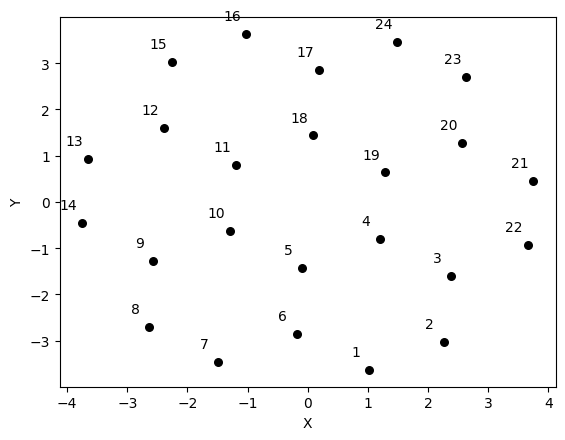

In [4]:
# Visualize carbon atoms in 2D
fig, ax = plt.subplots()
ax.scatter([atom[0] for atom in carbon_atoms_coord_2D], [atom[1] for atom in carbon_atoms_coord_2D], c='black', s=30)

# Add labels
for i, atom in enumerate(carbon_atoms_coord_2D):
    ax.annotate(str(i+1), atom, textcoords="offset points", xytext=(-10,10), ha='center')

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [5]:
coronene = Atoms(symbols='C16NC3BC3H12', positions=all_atoms_coord)
view(coronene, viewer='x3d')

# Generate Doping Arrays #

In [6]:
# Generate how many doped nutants there are in total
def num_doped_mutants():
    tot_num_mutants = 0
    for i in range(1, 13):
        num_mutants = comb(24, i) * comb(24-i, i)
        print(f"Number of mutants for {i} dopants: {num_mutants}")
        tot_num_mutants += num_mutants
    print(f"Total number of mutants: {tot_num_mutants}")
num_doped_mutants()

Number of mutants for 1 dopants: 552.0
Number of mutants for 2 dopants: 63756.0
Number of mutants for 3 dopants: 2691920.0
Number of mutants for 4 dopants: 51482970.0
Number of mutants for 5 dopants: 494236512.0
Number of mutants for 6 dopants: 2498640144.0
Number of mutants for 7 dopants: 6731030592.0
Number of mutants for 8 dopants: 9465511770.0
Number of mutants for 9 dopants: 6544057520.0
Number of mutants for 10 dopants: 1963217256.0
Number of mutants for 11 dopants: 194699232.0
Number of mutants for 12 dopants: 2704156.0
Total number of mutants: 27948336380.0


In [7]:
def generate_dx_arrays(num_dopant, num_mutant):
    mutations = np.zeros((num_mutant, 24), dtype=int)
    
    for i in range(num_mutant):
        dopant_indices = np.random.choice(24, num_dopant, replace=False)
        anti_dopant_indices = np.random.choice(
            np.setdiff1d(np.arange(24), dopant_indices), 
            num_dopant, 
            replace=False)
        
        mutations[i, dopant_indices] = 1
        mutations[i, anti_dopant_indices] = -1
    
    return mutations


def convert_to_charge_array(dx_array):
    charge_array = dx_array + 6
    h_elements = np.full((charge_array.shape[0], 12), 1)
    concatenated_array = np.concatenate((charge_array, h_elements), axis=1)
    return concatenated_array


def convert_to_string_array(dx_array):
    string_array = np.where(dx_array == 1, 'N', np.where(dx_array == -1, 'B', 'C'))
    h_elements = np.full((string_array.shape[0], 12), 'H')
    concatenated_array = np.concatenate((string_array, h_elements), axis=1)
    return concatenated_array


def compress_string(lst):
    compressed = ""
    count = 1
    for i in range(1, len(lst)):
        if lst[i] == lst[i-1]:
            count += 1
        else:
            compressed += lst[i-1]
            if count > 1:
                compressed += str(count)
            count = 1
    # Append the last letter and its count
    compressed += lst[-1]
    if count > 1:
        compressed += str(count)
    return compressed


def compress_str_arrays(str_array):
    return [compress_string(str_arr.tolist()) for str_arr in str_array]


def generate_mutant_str(num_dopant, num_mutant):
    doped_dx_arrays = generate_dx_arrays(num_dopant, num_mutant)
    doped_str_arrays = convert_to_string_array(doped_dx_arrays)
    compressed_str_array = compress_str_arrays(doped_str_arrays)
    return compressed_str_array

In [8]:
mutant_str = generate_mutant_str(3, 5)
print(mutant_str)

['C4NCBC4NC5NC2B2C2H12', 'CBC6NC2BNC7NBC2H12', 'NC2BC2BC2NC10NC2BH12', 'C4BCNCBCNC9NBC2H12', 'B2C2NCNC6NCBC8H12']


In [9]:
def generate_molecule_files(num_dopants, num_mutant):
    
    tar_filename = 'coronene_mutants.tar'
    print("tar file created")
    
    with tarfile.open(tar_filename, 'a') as tar:
        print("File opened.")
        for num_dope in num_dopants:
            # Create all mutant molecule strings with the specified number of dopents
            mutant_strs = generate_mutant_str(num_dope, num_mutant)
            
            for i, mutant in enumerate(mutant_strs):
                # Generate mutant molecule
                mutant_mol = Atoms(symbols=mutant, positions=all_atoms_coord)
                print("Created molecule ......................")
                # Save the molecule to an XYZ file
                xyz_filename = f'../Data/Coronene Raw Data/Mutant XYZ/BN_doped_coronene_{num_dope}_{i}.xyz'
                write(xyz_filename, mutant_mol, format='xyz')

                # Add the XYZ file to the tar file
                tar.add(xyz_filename)
                print("Added ......................")

                # Remove the XYZ file after adding it to the tar file
                os.remove(xyz_filename)

                # Yield the molecule to free up memory
                del mutant_mol

In [10]:
num_dopants = [i for i in range(1, 13)]
num_mutant = 200

tar_filename = 'coronene_mutants.tar'

with tarfile.open(tar_filename, 'a') as tar:
    for num_dope in num_dopants:
        # Create all mutant molecule strings with the specified number of dopents
        mutant_strs = generate_mutant_str(num_dope, num_mutant)
        
        for i, mutant in enumerate(mutant_strs):
            # Generate mutant molecule
            mutant_mol = Atoms(symbols=mutant, positions=all_atoms_coord)
            
            # Save the molecule to an XYZ file
            xyz_filename = f'../Data/Coronene Raw Data/Mutant XYZ/BN_doped_coronene_{num_dope}_{i}.xyz'
            write(xyz_filename, mutant_mol, format='xyz')

            # Add the XYZ file to the tar file
            # tar.add(xyz_filename)

            # Remove the XYZ file after adding it to the tar file
            # if i%50 != 0:
            #     os.remove(xyz_filename)

            # delete the molecule to free up memory
            del mutant_mol

In [11]:
import zipfile

def create_zip_file(directory_path, output_zip_path):
    with zipfile.ZipFile(output_zip_path, 'w') as zipf:
        # Iterate over all files and subdirectories in the given directory
        for root, _, files in os.walk(directory_path):
            for file in files:
                # Create the full path of the file
                file_path = os.path.join(root, file)
                # Add the file to the zip archive, preserving the directory structure
                zipf.write(file_path, arcname=file)

# Example usage
directory_path = '../Data/Coronene Raw Data/Mutant XYZ'  # Path to the directory you want to zip
output_zip_path = '../Data/Coronene Raw Data/Mutant_XYZ.zip'  # Path where you want to save the zip file

create_zip_file(directory_path, output_zip_path)